In [1]:
import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Lấy đường dẫn tuyệt đối của thư mục hiện tại (notebooks)
current_dir = os.getcwd()

# 2. Lấy đường dẫn của thư mục cha (MODELS)
project_root = os.path.dirname(current_dir)

# 3. Thêm thư mục cha vào hệ thống tìm kiếm module của Python
if project_root not in sys.path:
    sys.path.append(project_root)

# Kiểm tra xem đã thêm đúng chưa (Optional)
print(f"Project Root added: {project_root}")

from models.utils.loader import *
from models.utils.visualize import *
from models.metrics import *
from models.softmax_regression import *
from models.model_pixel import PixelSoftmax
from models.model_edge import EdgeSoftmax
from models.model_pca import PCASoftmax, check_pca_variance
from models.model_block import BlockSoftmax
from models.model_hog import HOGSoftmax
from models.softmax_regression import SoftmaxRegression
from models.metrics import confusion_matrix, accuracy, f1_score
from models.utils.visualize import *

Project Root added: d:\ML\Lab02\MODELS


In [2]:
# Load dataset and split into train, validation, test sets

datapath = os.path.join(project_root, 'data/mnist_data.npz')
X_train, y_train, X_test, y_test = load_dataset(datapath)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

def train_val_split(X: np.ndarray, y: np.ndarray, val_size: float = 0.1, random_seed: int = 42):
    np.random.seed(random_seed)
    N = X.shape[0]
    indices = np.random.permutation(N)
    val_count = int(N * val_size)
    val_indices = indices[:val_count]
    train_indices = indices[val_count:]
    return X[train_indices], X[val_indices], y[train_indices], y[val_indices]

X_train, X_val, y_train, y_val = train_val_split(X_train, y_train)

Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)


To retain 95% information: k = 154
To retain 99% information: k = 331


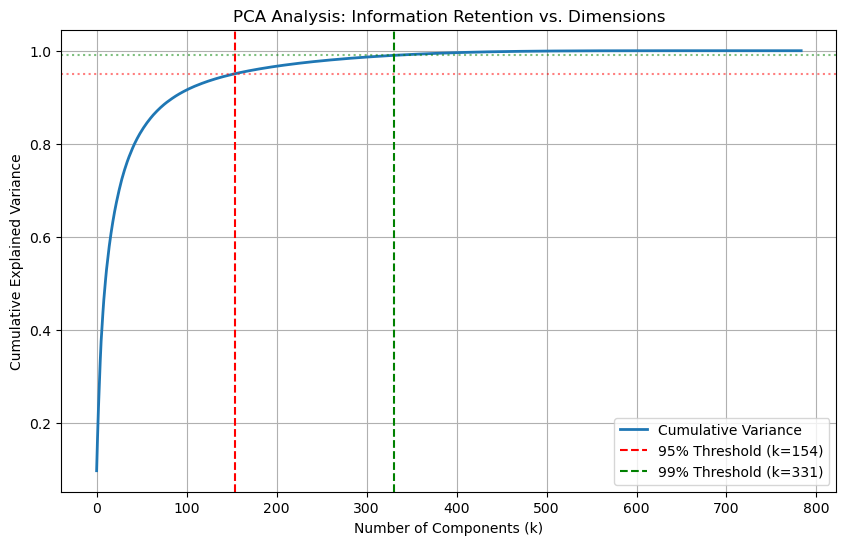

In [3]:
pca_features = check_pca_variance(X_train)

We want to retain at least 95% information so k = 154 is chosen

In [4]:
TRAIN_CONFIG = {
    'batch_size': X_train.shape[0],
    'verbose': True,
    'epochs': 100,
}

models = {
    "Pixel (Baseline)": PixelSoftmax(
        num_features=784, 
        num_classes=10, 
        optimizer=Adam()
    ),
    
    "Edge (Sobel)": EdgeSoftmax(
        num_features=784, 
        num_classes=10, 
        optimizer=Adam()
    ),
    
    "Block (14x14)": BlockSoftmax(
        grid_size=(14, 14), 
        num_classes=10, 
        optimizer=Adam()
    ),
    
    f"PCA (k={pca_features})": PCASoftmax(
        num_features=pca_features,
        num_classes=10, 
        optimizer=Adam()
    ),
    
    "HOG": HOGSoftmax(
        bins=9, 
        cell_grid=(7, 7), 
        num_classes=10, 
        optimizer=Adam()
    )
}

model_lrs = {
    "Pixel (Baseline)": 0.015,
    "Edge (Sobel)": 0.002,
    "Block (14x14)": 0.06,
    f"PCA (k={pca_features})": 0.1,
    "HOG": 0.2
}

These hyperparameter are fine-tuned based on the loss convergence curves below - (we want to achieve stable, smooth curve):
- The number of epochs is chosen so that all models are close to convergence.
- The learning rate is chosen based on each model’s sensitivity, ensuring a smooth convergence curve.

In [5]:
# TRAINING AND EVALUATION LOOP

results = []
train_loss = {} # Model loss history
valid_loss = {} # Model validation loss history

for name, model in models.items():
    print(f"Training Model: {name}")

    lr = model_lrs[name]

    start_time = time.time()

    # # Start training
    model.fit(X_train, y_train, X_val=X_val, y_val=y_val, learning_rate=lr, **TRAIN_CONFIG)

    train_time = time.time() - start_time

    # 2. Evaluate on test set
    y_pred = model.predict(X_test)
    test_acc = accuracy(y_test, y_pred)

    # 3. Store results
    results.append({
        "Model": name,
        "Accuracy": test_acc,
        "Precision": precision_score(y_test, y_pred, num_classes=10, average='macro'),
        "Recall": recall_score(y_test, y_pred, num_classes=10, average='macro'),
        "F1-Score": f1_score(y_test, y_pred, num_classes=10, average='macro'),
        "Time (s)": train_time,
        "Num Features": model.num_features
    })

    # Store loss history
    train_loss[name] = model.loss_history

print(f"\n{'='*20} BENCHMARK COMPLETED {'='*20}")

Training Model: Pixel (Baseline)


Output()

Epoch 1/100 - Validation Accuracy: 63.48%

Epoch 2/100 - Validation Accuracy: 76.33%

Epoch 3/100 - Validation Accuracy: 80.00%

Epoch 4/100 - Validation Accuracy: 81.08%

Epoch 5/100 - Validation Accuracy: 81.40%

Epoch 6/100 - Validation Accuracy: 82.15%

Epoch 7/100 - Validation Accuracy: 83.62%

Epoch 8/100 - Validation Accuracy: 84.87%

Epoch 9/100 - Validation Accuracy: 85.72%

Epoch 10/100 - Validation Accuracy: 86.38%

Epoch 11/100 - Validation Accuracy: 86.82%

Epoch 12/100 - Validation Accuracy: 87.27%

Epoch 13/100 - Validation Accuracy: 87.62%

Epoch 14/100 - Validation Accuracy: 88.07%

Epoch 15/100 - Validation Accuracy: 88.42%

Epoch 16/100 - Validation Accuracy: 88.68%

Epoch 17/100 - Validation Accuracy: 88.90%

Epoch 18/100 - Validation Accuracy: 89.02%

Epoch 19/100 - Validation Accuracy: 89.08%

Epoch 20/100 - Validation Accuracy: 89.25%

Epoch 21/100 - Validation Accuracy: 89.35%

Epoch 22/100 - Validation Accuracy: 89.45%

Epoch 23/100 - Validation Accuracy: 89.60%

Epoch 24/100 - Validation Accuracy: 89.65%

Epoch 25/100 - Validation Accuracy: 89.75%

Epoch 26/100 - Validation Accuracy: 89.93%

Epoch 27/100 - Validation Accuracy: 90.12%

Epoch 28/100 - Validation Accuracy: 90.30%

Epoch 29/100 - Validation Accuracy: 90.33%

Epoch 30/100 - Validation Accuracy: 90.35%

Epoch 31/100 - Validation Accuracy: 90.52%

Epoch 32/100 - Validation Accuracy: 90.58%

Epoch 33/100 - Validation Accuracy: 90.73%

Epoch 34/100 - Validation Accuracy: 90.78%

Epoch 35/100 - Validation Accuracy: 90.82%

Epoch 36/100 - Validation Accuracy: 90.92%

Epoch 37/100 - Validation Accuracy: 91.00%

Epoch 38/100 - Validation Accuracy: 91.17%

Epoch 39/100 - Validation Accuracy: 91.28%

Epoch 40/100 - Validation Accuracy: 91.30%

Epoch 41/100 - Validation Accuracy: 91.30%

Epoch 42/100 - Validation Accuracy: 91.33%

Epoch 43/100 - Validation Accuracy: 91.38%

Epoch 44/100 - Validation Accuracy: 91.45%

Epoch 45/100 - Validation Accuracy: 91.52%

Epoch 46/100 - Validation Accuracy: 91.55%

Epoch 47/100 - Validation Accuracy: 91.60%

Epoch 48/100 - Validation Accuracy: 91.65%

Epoch 49/100 - Validation Accuracy: 91.70%

Epoch 50/100 - Validation Accuracy: 91.72%

Epoch 51/100 - Validation Accuracy: 91.77%

Epoch 52/100 - Validation Accuracy: 91.78%

Epoch 53/100 - Validation Accuracy: 91.78%

Epoch 54/100 - Validation Accuracy: 91.85%

Epoch 55/100 - Validation Accuracy: 91.83%

Epoch 56/100 - Validation Accuracy: 91.87%

Epoch 57/100 - Validation Accuracy: 91.92%

Epoch 58/100 - Validation Accuracy: 91.95%

Epoch 59/100 - Validation Accuracy: 91.98%

Epoch 60/100 - Validation Accuracy: 91.98%

Epoch 61/100 - Validation Accuracy: 91.97%

Epoch 62/100 - Validation Accuracy: 92.02%

Epoch 63/100 - Validation Accuracy: 92.00%

Epoch 64/100 - Validation Accuracy: 92.03%

Epoch 65/100 - Validation Accuracy: 92.03%

Epoch 66/100 - Validation Accuracy: 92.03%

Epoch 67/100 - Validation Accuracy: 92.08%

Epoch 68/100 - Validation Accuracy: 92.12%

Epoch 69/100 - Validation Accuracy: 92.13%

Epoch 70/100 - Validation Accuracy: 92.13%

Epoch 71/100 - Validation Accuracy: 92.18%

Epoch 72/100 - Validation Accuracy: 92.27%

Epoch 73/100 - Validation Accuracy: 92.35%

Epoch 74/100 - Validation Accuracy: 92.35%

Epoch 75/100 - Validation Accuracy: 92.40%

Epoch 76/100 - Validation Accuracy: 92.40%

Epoch 77/100 - Validation Accuracy: 92.45%

Epoch 78/100 - Validation Accuracy: 92.47%

Epoch 79/100 - Validation Accuracy: 92.50%

Epoch 80/100 - Validation Accuracy: 92.52%

Epoch 81/100 - Validation Accuracy: 92.55%

Epoch 82/100 - Validation Accuracy: 92.50%

Epoch 83/100 - Validation Accuracy: 92.48%

Epoch 84/100 - Validation Accuracy: 92.50%

Epoch 85/100 - Validation Accuracy: 92.47%

Epoch 86/100 - Validation Accuracy: 92.48%

Epoch 87/100 - Validation Accuracy: 92.48%

Epoch 88/100 - Validation Accuracy: 92.50%

Epoch 89/100 - Validation Accuracy: 92.55%

Epoch 90/100 - Validation Accuracy: 92.60%

Epoch 91/100 - Validation Accuracy: 92.60%

Epoch 92/100 - Validation Accuracy: 92.62%

Epoch 93/100 - Validation Accuracy: 92.60%

Epoch 94/100 - Validation Accuracy: 92.62%

Epoch 95/100 - Validation Accuracy: 92.62%

Epoch 96/100 - Validation Accuracy: 92.63%

Epoch 97/100 - Validation Accuracy: 92.65%

Epoch 98/100 - Validation Accuracy: 92.68%

Epoch 99/100 - Validation Accuracy: 92.70%

Epoch 100/100 - Validation Accuracy: 92.72%

Training Model: Edge (Sobel)
Feature Extraction: Computing Sobel Edges...


Output()

Epoch 1/100 - Validation Accuracy: 49.50%

Epoch 2/100 - Validation Accuracy: 71.85%

Epoch 3/100 - Validation Accuracy: 74.57%

Epoch 4/100 - Validation Accuracy: 76.65%

Epoch 5/100 - Validation Accuracy: 75.53%

Epoch 6/100 - Validation Accuracy: 76.10%

Epoch 7/100 - Validation Accuracy: 77.43%

Epoch 8/100 - Validation Accuracy: 78.83%

Epoch 9/100 - Validation Accuracy: 79.75%

Epoch 10/100 - Validation Accuracy: 80.57%

Epoch 11/100 - Validation Accuracy: 81.05%

Epoch 12/100 - Validation Accuracy: 81.62%

Epoch 13/100 - Validation Accuracy: 82.07%

Epoch 14/100 - Validation Accuracy: 82.62%

Epoch 15/100 - Validation Accuracy: 83.00%

Epoch 16/100 - Validation Accuracy: 83.62%

Epoch 17/100 - Validation Accuracy: 83.72%

Epoch 18/100 - Validation Accuracy: 84.18%

Epoch 19/100 - Validation Accuracy: 84.32%

Epoch 20/100 - Validation Accuracy: 84.45%

Epoch 21/100 - Validation Accuracy: 84.73%

Epoch 22/100 - Validation Accuracy: 84.82%

Epoch 23/100 - Validation Accuracy: 84.98%

Epoch 24/100 - Validation Accuracy: 85.18%

Epoch 25/100 - Validation Accuracy: 85.28%

Epoch 26/100 - Validation Accuracy: 85.42%

Epoch 27/100 - Validation Accuracy: 85.45%

Epoch 28/100 - Validation Accuracy: 85.73%

Epoch 29/100 - Validation Accuracy: 85.85%

Epoch 30/100 - Validation Accuracy: 85.95%

Epoch 31/100 - Validation Accuracy: 86.05%

Epoch 32/100 - Validation Accuracy: 86.10%

Epoch 33/100 - Validation Accuracy: 86.18%

Epoch 34/100 - Validation Accuracy: 86.22%

Epoch 35/100 - Validation Accuracy: 86.30%

Epoch 36/100 - Validation Accuracy: 86.38%

Epoch 37/100 - Validation Accuracy: 86.53%

Epoch 38/100 - Validation Accuracy: 86.55%

Epoch 39/100 - Validation Accuracy: 86.57%

Epoch 40/100 - Validation Accuracy: 86.53%

Epoch 41/100 - Validation Accuracy: 86.73%

Epoch 42/100 - Validation Accuracy: 86.78%

Epoch 43/100 - Validation Accuracy: 86.77%

Epoch 44/100 - Validation Accuracy: 86.87%

Epoch 45/100 - Validation Accuracy: 86.93%

Epoch 46/100 - Validation Accuracy: 87.03%

Epoch 47/100 - Validation Accuracy: 87.05%

Epoch 48/100 - Validation Accuracy: 87.05%

Epoch 49/100 - Validation Accuracy: 87.15%

Epoch 50/100 - Validation Accuracy: 87.18%

Epoch 51/100 - Validation Accuracy: 87.28%

Epoch 52/100 - Validation Accuracy: 87.32%

Epoch 54/100 - Validation Accuracy: 87.50%

Epoch 55/100 - Validation Accuracy: 87.48%

Epoch 56/100 - Validation Accuracy: 87.50%

Epoch 57/100 - Validation Accuracy: 87.52%

Epoch 58/100 - Validation Accuracy: 87.58%

Epoch 59/100 - Validation Accuracy: 87.67%

Epoch 60/100 - Validation Accuracy: 87.78%

Epoch 61/100 - Validation Accuracy: 87.87%

Epoch 62/100 - Validation Accuracy: 87.88%

Epoch 63/100 - Validation Accuracy: 87.98%

Epoch 64/100 - Validation Accuracy: 88.10%

Epoch 65/100 - Validation Accuracy: 88.13%

Epoch 66/100 - Validation Accuracy: 88.17%

Epoch 67/100 - Validation Accuracy: 88.18%

Epoch 68/100 - Validation Accuracy: 88.20%

Epoch 69/100 - Validation Accuracy: 88.18%

Epoch 70/100 - Validation Accuracy: 88.22%

Epoch 71/100 - Validation Accuracy: 88.27%

Epoch 72/100 - Validation Accuracy: 88.27%

Epoch 73/100 - Validation Accuracy: 88.27%

Epoch 74/100 - Validation Accuracy: 88.25%

Epoch 75/100 - Validation Accuracy: 88.28%

Epoch 76/100 - Validation Accuracy: 88.27%

Epoch 78/100 - Validation Accuracy: 88.35%

Epoch 80/100 - Validation Accuracy: 88.42%

Epoch 81/100 - Validation Accuracy: 88.43%

Epoch 82/100 - Validation Accuracy: 88.48%

Epoch 83/100 - Validation Accuracy: 88.45%

Epoch 84/100 - Validation Accuracy: 88.48%

Epoch 85/100 - Validation Accuracy: 88.52%

Epoch 86/100 - Validation Accuracy: 88.52%

Epoch 87/100 - Validation Accuracy: 88.55%

Epoch 88/100 - Validation Accuracy: 88.57%

Epoch 89/100 - Validation Accuracy: 88.53%

Epoch 90/100 - Validation Accuracy: 88.58%

Epoch 91/100 - Validation Accuracy: 88.58%

Epoch 92/100 - Validation Accuracy: 88.60%

Epoch 93/100 - Validation Accuracy: 88.60%

Epoch 94/100 - Validation Accuracy: 88.60%

Epoch 95/100 - Validation Accuracy: 88.63%

Epoch 96/100 - Validation Accuracy: 88.67%

Epoch 97/100 - Validation Accuracy: 88.67%

Epoch 98/100 - Validation Accuracy: 88.67%

Epoch 99/100 - Validation Accuracy: 88.68%

Epoch 100/100 - Validation Accuracy: 88.72%

Training Model: Block (14x14)
Applying Block Averaging (14, 14)...
Block Feature shape: (54000, 196)


Output()

Epoch 1/100 - Validation Accuracy: 64.88%

Epoch 2/100 - Validation Accuracy: 75.32%

Epoch 3/100 - Validation Accuracy: 79.52%

Epoch 4/100 - Validation Accuracy: 80.80%

Epoch 5/100 - Validation Accuracy: 81.05%

Epoch 6/100 - Validation Accuracy: 81.87%

Epoch 7/100 - Validation Accuracy: 83.37%

Epoch 8/100 - Validation Accuracy: 84.57%

Epoch 9/100 - Validation Accuracy: 85.62%

Epoch 10/100 - Validation Accuracy: 86.10%

Epoch 11/100 - Validation Accuracy: 86.60%

Epoch 12/100 - Validation Accuracy: 87.02%

Epoch 13/100 - Validation Accuracy: 87.13%

Epoch 14/100 - Validation Accuracy: 87.53%

Epoch 15/100 - Validation Accuracy: 88.07%

Epoch 16/100 - Validation Accuracy: 88.22%

Epoch 17/100 - Validation Accuracy: 88.42%

Epoch 18/100 - Validation Accuracy: 88.72%

Epoch 19/100 - Validation Accuracy: 88.85%

Epoch 20/100 - Validation Accuracy: 89.03%

Epoch 21/100 - Validation Accuracy: 89.22%

Epoch 22/100 - Validation Accuracy: 89.35%

Epoch 23/100 - Validation Accuracy: 89.58%

Epoch 24/100 - Validation Accuracy: 89.70%

Epoch 25/100 - Validation Accuracy: 89.73%

Epoch 26/100 - Validation Accuracy: 89.77%

Epoch 27/100 - Validation Accuracy: 89.88%

Epoch 28/100 - Validation Accuracy: 90.08%

Epoch 29/100 - Validation Accuracy: 90.33%

Epoch 30/100 - Validation Accuracy: 90.43%

Epoch 31/100 - Validation Accuracy: 90.48%

Epoch 32/100 - Validation Accuracy: 90.65%

Epoch 33/100 - Validation Accuracy: 90.82%

Epoch 34/100 - Validation Accuracy: 90.93%

Epoch 35/100 - Validation Accuracy: 90.92%

Epoch 36/100 - Validation Accuracy: 91.07%

Epoch 37/100 - Validation Accuracy: 91.05%

Epoch 38/100 - Validation Accuracy: 91.10%

Epoch 39/100 - Validation Accuracy: 91.13%

Epoch 40/100 - Validation Accuracy: 91.20%

Epoch 41/100 - Validation Accuracy: 91.25%

Epoch 42/100 - Validation Accuracy: 91.32%

Epoch 43/100 - Validation Accuracy: 91.38%

Epoch 44/100 - Validation Accuracy: 91.42%

Epoch 45/100 - Validation Accuracy: 91.40%

Epoch 46/100 - Validation Accuracy: 91.47%

Epoch 47/100 - Validation Accuracy: 91.48%

Epoch 48/100 - Validation Accuracy: 91.52%

Epoch 49/100 - Validation Accuracy: 91.52%

Epoch 50/100 - Validation Accuracy: 91.60%

Epoch 51/100 - Validation Accuracy: 91.67%

Epoch 53/100 - Validation Accuracy: 91.78%

Epoch 54/100 - Validation Accuracy: 91.78%

Epoch 55/100 - Validation Accuracy: 91.82%

Epoch 56/100 - Validation Accuracy: 91.82%

Epoch 57/100 - Validation Accuracy: 91.82%

Epoch 58/100 - Validation Accuracy: 91.87%

Epoch 59/100 - Validation Accuracy: 91.88%

Epoch 60/100 - Validation Accuracy: 91.85%

Epoch 61/100 - Validation Accuracy: 91.85%

Epoch 62/100 - Validation Accuracy: 91.87%

Epoch 63/100 - Validation Accuracy: 91.90%

Epoch 64/100 - Validation Accuracy: 91.95%

Epoch 65/100 - Validation Accuracy: 91.98%

Epoch 66/100 - Validation Accuracy: 92.02%

Epoch 67/100 - Validation Accuracy: 92.02%

Epoch 68/100 - Validation Accuracy: 92.07%

Epoch 69/100 - Validation Accuracy: 92.12%

Epoch 70/100 - Validation Accuracy: 92.12%

Epoch 71/100 - Validation Accuracy: 92.13%

Epoch 72/100 - Validation Accuracy: 92.17%

Epoch 73/100 - Validation Accuracy: 92.22%

Epoch 74/100 - Validation Accuracy: 92.20%

Epoch 75/100 - Validation Accuracy: 92.20%

Epoch 76/100 - Validation Accuracy: 92.23%

Epoch 77/100 - Validation Accuracy: 92.23%

Epoch 78/100 - Validation Accuracy: 92.32%

Epoch 79/100 - Validation Accuracy: 92.33%

Epoch 80/100 - Validation Accuracy: 92.38%

Epoch 81/100 - Validation Accuracy: 92.38%

Epoch 82/100 - Validation Accuracy: 92.40%

Epoch 83/100 - Validation Accuracy: 92.42%

Epoch 84/100 - Validation Accuracy: 92.42%

Epoch 85/100 - Validation Accuracy: 92.42%

Epoch 86/100 - Validation Accuracy: 92.40%

Epoch 87/100 - Validation Accuracy: 92.40%

Epoch 88/100 - Validation Accuracy: 92.38%

Epoch 89/100 - Validation Accuracy: 92.37%

Epoch 90/100 - Validation Accuracy: 92.40%

Epoch 91/100 - Validation Accuracy: 92.45%

Epoch 92/100 - Validation Accuracy: 92.43%

Epoch 93/100 - Validation Accuracy: 92.40%

Epoch 94/100 - Validation Accuracy: 92.42%

Epoch 95/100 - Validation Accuracy: 92.42%

Epoch 96/100 - Validation Accuracy: 92.48%

Epoch 97/100 - Validation Accuracy: 92.48%

Epoch 98/100 - Validation Accuracy: 92.47%

Epoch 99/100 - Validation Accuracy: 92.47%

Epoch 100/100 - Validation Accuracy: 92.52%

Training Model: PCA (k=154)


Output()

Epoch 1/100 - Validation Accuracy: 72.27%

Epoch 2/100 - Validation Accuracy: 79.37%

Epoch 3/100 - Validation Accuracy: 82.57%

Epoch 4/100 - Validation Accuracy: 84.75%

Epoch 5/100 - Validation Accuracy: 86.17%

Epoch 6/100 - Validation Accuracy: 87.38%

Epoch 7/100 - Validation Accuracy: 88.32%

Epoch 8/100 - Validation Accuracy: 88.85%

Epoch 9/100 - Validation Accuracy: 88.97%

Epoch 10/100 - Validation Accuracy: 89.42%

Epoch 11/100 - Validation Accuracy: 89.67%

Epoch 12/100 - Validation Accuracy: 89.83%

Epoch 13/100 - Validation Accuracy: 89.93%

Epoch 14/100 - Validation Accuracy: 90.13%

Epoch 15/100 - Validation Accuracy: 90.32%

Epoch 16/100 - Validation Accuracy: 90.65%

Epoch 17/100 - Validation Accuracy: 90.90%

Epoch 18/100 - Validation Accuracy: 91.07%

Epoch 19/100 - Validation Accuracy: 91.00%

Epoch 20/100 - Validation Accuracy: 91.03%

Epoch 21/100 - Validation Accuracy: 91.07%

Epoch 22/100 - Validation Accuracy: 91.10%

Epoch 23/100 - Validation Accuracy: 91.02%

Epoch 24/100 - Validation Accuracy: 91.10%

Epoch 25/100 - Validation Accuracy: 91.13%

Epoch 26/100 - Validation Accuracy: 91.20%

Epoch 27/100 - Validation Accuracy: 91.35%

Epoch 28/100 - Validation Accuracy: 91.40%

Epoch 29/100 - Validation Accuracy: 91.52%

Epoch 30/100 - Validation Accuracy: 91.50%

Epoch 31/100 - Validation Accuracy: 91.52%

Epoch 33/100 - Validation Accuracy: 91.72%

Epoch 34/100 - Validation Accuracy: 91.75%

Epoch 35/100 - Validation Accuracy: 91.80%

Epoch 36/100 - Validation Accuracy: 91.93%

Epoch 37/100 - Validation Accuracy: 91.98%

Epoch 38/100 - Validation Accuracy: 91.98%

Epoch 39/100 - Validation Accuracy: 91.97%

Epoch 40/100 - Validation Accuracy: 91.97%

Epoch 41/100 - Validation Accuracy: 91.95%

Epoch 42/100 - Validation Accuracy: 91.92%

Epoch 43/100 - Validation Accuracy: 91.93%

Epoch 44/100 - Validation Accuracy: 91.97%

Epoch 45/100 - Validation Accuracy: 91.97%

Epoch 46/100 - Validation Accuracy: 91.95%

Epoch 47/100 - Validation Accuracy: 91.90%

Epoch 48/100 - Validation Accuracy: 91.97%

Epoch 49/100 - Validation Accuracy: 91.93%

Epoch 50/100 - Validation Accuracy: 91.95%

Epoch 51/100 - Validation Accuracy: 91.97%

Epoch 52/100 - Validation Accuracy: 92.02%

Epoch 53/100 - Validation Accuracy: 92.05%

Epoch 54/100 - Validation Accuracy: 92.10%

Epoch 55/100 - Validation Accuracy: 92.08%

Epoch 56/100 - Validation Accuracy: 92.10%

Epoch 57/100 - Validation Accuracy: 92.07%

Epoch 58/100 - Validation Accuracy: 92.03%

Epoch 59/100 - Validation Accuracy: 92.00%

Epoch 60/100 - Validation Accuracy: 92.05%

Epoch 61/100 - Validation Accuracy: 92.05%

Epoch 62/100 - Validation Accuracy: 92.07%

Epoch 63/100 - Validation Accuracy: 92.12%

Epoch 64/100 - Validation Accuracy: 92.12%

Epoch 65/100 - Validation Accuracy: 92.12%

Epoch 66/100 - Validation Accuracy: 92.10%

Epoch 67/100 - Validation Accuracy: 92.05%

Epoch 68/100 - Validation Accuracy: 92.08%

Epoch 69/100 - Validation Accuracy: 92.10%

Epoch 70/100 - Validation Accuracy: 92.08%

Epoch 71/100 - Validation Accuracy: 92.10%

Epoch 72/100 - Validation Accuracy: 92.07%

Epoch 73/100 - Validation Accuracy: 92.02%

Epoch 74/100 - Validation Accuracy: 92.03%

Epoch 75/100 - Validation Accuracy: 92.05%

Epoch 76/100 - Validation Accuracy: 92.10%

Epoch 77/100 - Validation Accuracy: 92.13%

Epoch 78/100 - Validation Accuracy: 92.15%

Epoch 79/100 - Validation Accuracy: 92.12%

Epoch 80/100 - Validation Accuracy: 92.13%

Epoch 81/100 - Validation Accuracy: 92.12%

Epoch 82/100 - Validation Accuracy: 92.15%

Epoch 83/100 - Validation Accuracy: 92.15%

Epoch 84/100 - Validation Accuracy: 92.17%

Epoch 85/100 - Validation Accuracy: 92.15%

Epoch 86/100 - Validation Accuracy: 92.17%

Epoch 87/100 - Validation Accuracy: 92.13%

Epoch 88/100 - Validation Accuracy: 92.12%

Epoch 89/100 - Validation Accuracy: 92.13%

Epoch 90/100 - Validation Accuracy: 92.12%

Epoch 91/100 - Validation Accuracy: 92.08%

Epoch 92/100 - Validation Accuracy: 92.07%

Epoch 93/100 - Validation Accuracy: 92.10%

Epoch 94/100 - Validation Accuracy: 92.10%

Epoch 95/100 - Validation Accuracy: 92.10%

Epoch 96/100 - Validation Accuracy: 92.13%

Epoch 97/100 - Validation Accuracy: 92.15%

Epoch 98/100 - Validation Accuracy: 92.13%

Epoch 99/100 - Validation Accuracy: 92.13%

Epoch 100/100 - Validation Accuracy: 92.12%

Training Model: HOG
Extracting HOG features (Vectorized Refactored)...


Output()

HOG Feature shape: (54000, 441)


Epoch 1/100 - Validation Accuracy: 79.58%

Epoch 2/100 - Validation Accuracy: 90.48%

Epoch 3/100 - Validation Accuracy: 91.12%

Epoch 4/100 - Validation Accuracy: 92.38%

Epoch 5/100 - Validation Accuracy: 93.08%

Epoch 6/100 - Validation Accuracy: 93.28%

Epoch 7/100 - Validation Accuracy: 93.85%

Epoch 8/100 - Validation Accuracy: 94.15%

Epoch 9/100 - Validation Accuracy: 94.52%

Epoch 10/100 - Validation Accuracy: 94.72%

Epoch 11/100 - Validation Accuracy: 95.05%

Epoch 12/100 - Validation Accuracy: 95.08%

Epoch 13/100 - Validation Accuracy: 95.23%

Epoch 14/100 - Validation Accuracy: 95.38%

Epoch 15/100 - Validation Accuracy: 95.52%

Epoch 16/100 - Validation Accuracy: 95.60%

Epoch 17/100 - Validation Accuracy: 95.65%

Epoch 18/100 - Validation Accuracy: 95.73%

Epoch 19/100 - Validation Accuracy: 95.80%

Epoch 20/100 - Validation Accuracy: 95.87%

Epoch 21/100 - Validation Accuracy: 95.95%

Epoch 22/100 - Validation Accuracy: 96.00%

Epoch 23/100 - Validation Accuracy: 96.08%

Epoch 24/100 - Validation Accuracy: 96.15%

Epoch 25/100 - Validation Accuracy: 96.23%

Epoch 26/100 - Validation Accuracy: 96.30%

Epoch 27/100 - Validation Accuracy: 96.37%

Epoch 28/100 - Validation Accuracy: 96.37%

Epoch 29/100 - Validation Accuracy: 96.35%

Epoch 30/100 - Validation Accuracy: 96.37%

Epoch 31/100 - Validation Accuracy: 96.45%

Epoch 32/100 - Validation Accuracy: 96.50%

Epoch 33/100 - Validation Accuracy: 96.57%

Epoch 34/100 - Validation Accuracy: 96.60%

Epoch 35/100 - Validation Accuracy: 96.57%

Epoch 36/100 - Validation Accuracy: 96.60%

Epoch 37/100 - Validation Accuracy: 96.62%

Epoch 38/100 - Validation Accuracy: 96.63%

Epoch 39/100 - Validation Accuracy: 96.62%

Epoch 40/100 - Validation Accuracy: 96.63%

Epoch 41/100 - Validation Accuracy: 96.67%

Epoch 42/100 - Validation Accuracy: 96.67%

Epoch 43/100 - Validation Accuracy: 96.73%

Epoch 44/100 - Validation Accuracy: 96.78%

Epoch 45/100 - Validation Accuracy: 96.88%

Epoch 46/100 - Validation Accuracy: 96.88%

Epoch 47/100 - Validation Accuracy: 96.92%

Epoch 48/100 - Validation Accuracy: 96.93%

Epoch 49/100 - Validation Accuracy: 96.95%

Epoch 50/100 - Validation Accuracy: 96.97%

Epoch 51/100 - Validation Accuracy: 97.03%

Epoch 52/100 - Validation Accuracy: 97.05%

Epoch 53/100 - Validation Accuracy: 97.12%

Epoch 54/100 - Validation Accuracy: 97.13%

Epoch 55/100 - Validation Accuracy: 97.12%

Epoch 56/100 - Validation Accuracy: 97.12%

Epoch 57/100 - Validation Accuracy: 97.15%

Epoch 58/100 - Validation Accuracy: 97.15%

Epoch 59/100 - Validation Accuracy: 97.18%

Epoch 60/100 - Validation Accuracy: 97.20%

Epoch 61/100 - Validation Accuracy: 97.22%

Epoch 62/100 - Validation Accuracy: 97.25%

Epoch 63/100 - Validation Accuracy: 97.28%

Epoch 64/100 - Validation Accuracy: 97.30%

Epoch 65/100 - Validation Accuracy: 97.30%

Epoch 66/100 - Validation Accuracy: 97.32%

Epoch 67/100 - Validation Accuracy: 97.32%

Epoch 68/100 - Validation Accuracy: 97.32%

Epoch 69/100 - Validation Accuracy: 97.33%

Epoch 70/100 - Validation Accuracy: 97.33%

Epoch 71/100 - Validation Accuracy: 97.32%

Epoch 72/100 - Validation Accuracy: 97.35%

Epoch 73/100 - Validation Accuracy: 97.38%

Epoch 74/100 - Validation Accuracy: 97.40%

Epoch 75/100 - Validation Accuracy: 97.40%

Epoch 76/100 - Validation Accuracy: 97.40%

Epoch 78/100 - Validation Accuracy: 97.40%

Epoch 79/100 - Validation Accuracy: 97.40%

Epoch 80/100 - Validation Accuracy: 97.42%

Epoch 81/100 - Validation Accuracy: 97.45%

Epoch 82/100 - Validation Accuracy: 97.47%

Epoch 83/100 - Validation Accuracy: 97.47%

Epoch 84/100 - Validation Accuracy: 97.47%

Epoch 85/100 - Validation Accuracy: 97.50%

Epoch 86/100 - Validation Accuracy: 97.50%

Epoch 87/100 - Validation Accuracy: 97.50%

Epoch 88/100 - Validation Accuracy: 97.52%

Epoch 89/100 - Validation Accuracy: 97.53%

Epoch 90/100 - Validation Accuracy: 97.55%

Epoch 91/100 - Validation Accuracy: 97.58%

Epoch 92/100 - Validation Accuracy: 97.63%

Epoch 93/100 - Validation Accuracy: 97.65%

Epoch 94/100 - Validation Accuracy: 97.68%

Epoch 95/100 - Validation Accuracy: 97.68%

Epoch 96/100 - Validation Accuracy: 97.70%

Epoch 97/100 - Validation Accuracy: 97.70%

Epoch 98/100 - Validation Accuracy: 97.72%

Epoch 99/100 - Validation Accuracy: 97.72%

Epoch 100/100 - Validation Accuracy: 97.72%


==================== BENCHMARK COMPLETED ====================


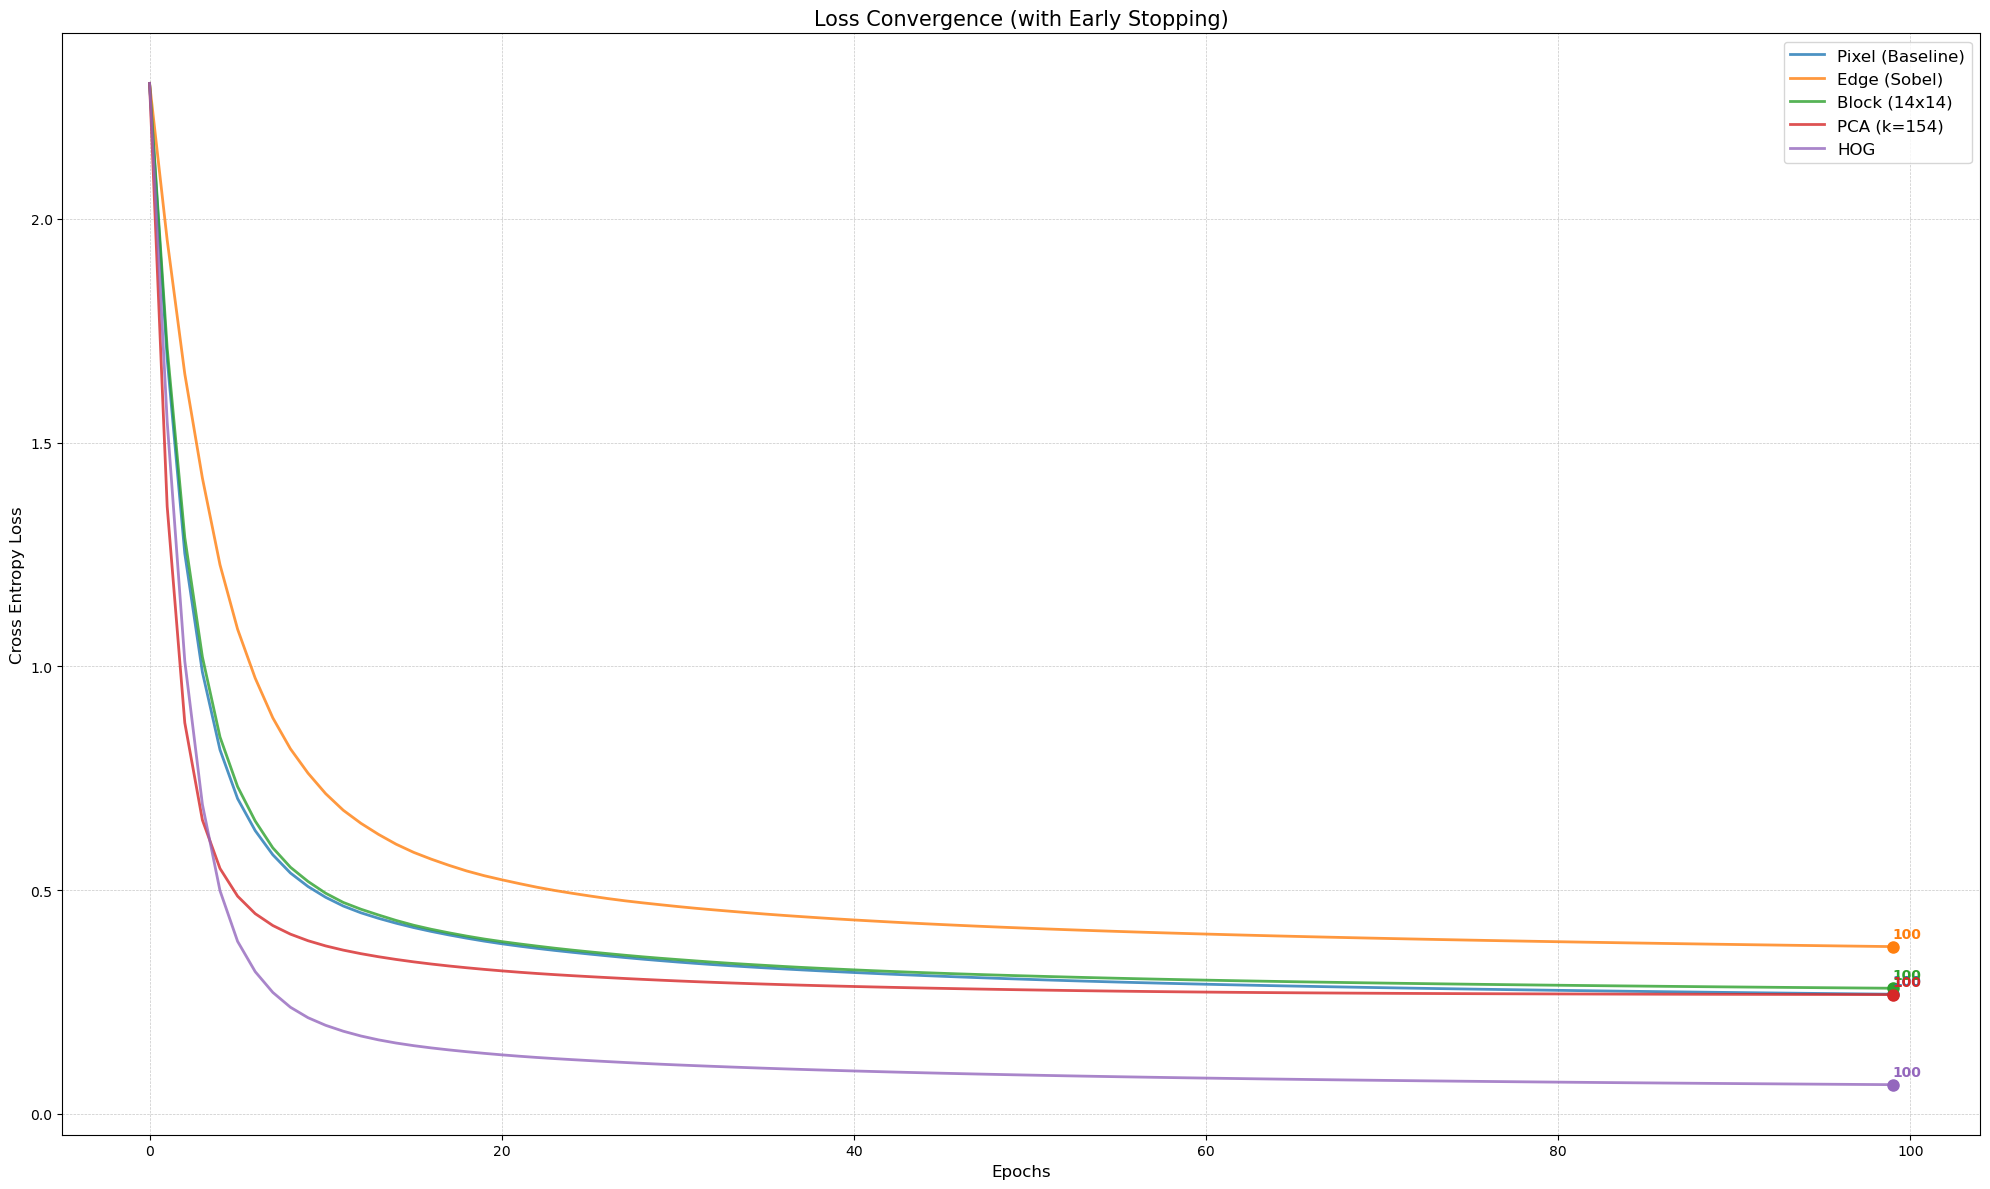

In [6]:
plt.figure(figsize=(20, 12))

# Tạo bảng màu
model_names = train_loss.keys()
colors = plt.cm.tab10(range(len(model_names)))
color_map = dict(zip(model_names, colors))     

# Plot train loss
for idx, (name, loss_hist) in enumerate(train_loss.items()):
    epochs_range = range(len(loss_hist)) 
    color = color_map[name]
    
    plt.plot(epochs_range, loss_hist, 
             label=f"{name}", 
             linewidth=2,
             color=color,
             alpha=0.8)
    
    final_epoch = len(loss_hist) - 1
    final_loss = loss_hist[-1]
    
    plt.plot(final_epoch, final_loss, marker='o', markersize=8, color=color)
    
    plt.text(final_epoch, final_loss + 0.02, 
             f"{final_epoch+1}", 
             color=color, fontweight='bold', fontsize=10)

plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Cross Entropy Loss', fontsize=12)
plt.title('Loss Convergence (with Early Stopping)', fontsize=15)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

1. Clear Separation of Convergence Speed:  
    - **"Smart" Group (PCA, HOG):**  
     The loss curve drops sharply and reaches its minimum very early (around the first 20–30 epochs).  
     This indicates that good feature extraction helps remove noise and mitigates the curse of
     dimensionality, allowing the model to learn faster.

   - **"Diligent" Group (Pixel, Block, Edge):**  
     The loss curve decreases more slowly and gently.  
     These methods require more time to thoroughly explore the high-dimensional and noisy raw data space.

2. High Stability:  
   - In the later stage (Epoch 100+), all curves become flat (plateau) and very smooth,
     showing no signs of oscillation (zigzag).  
   - This confirms that the Learning Rate has been appropriately set, and the models
     have extracted nearly all possible information from the input data.


Feature Engineering (HOG/PCA) enables the models to “learn faster and learn better,” while raw data methods (Pixel/Block) require greater patience (more epochs) to reach comparable performance.


,Model,Accuracy,Precision,Recall,F1-Score,Time (s),Num Features
4,HOG,0.976200,0.976097,0.976148,0.976105,46.509735,441
0,Pixel (Baseline),0.925100,0.924290,0.924103,0.924031,14.881872,784
3,PCA (k=154),0.923700,0.922821,0.922584,0.922613,7.963268,154
2,Block (14x14),0.921900,0.920953,0.920851,0.920784,8.166933,196
1,Edge (Sobel),0.887900,0.886996,0.886308,0.886316,27.515728,784


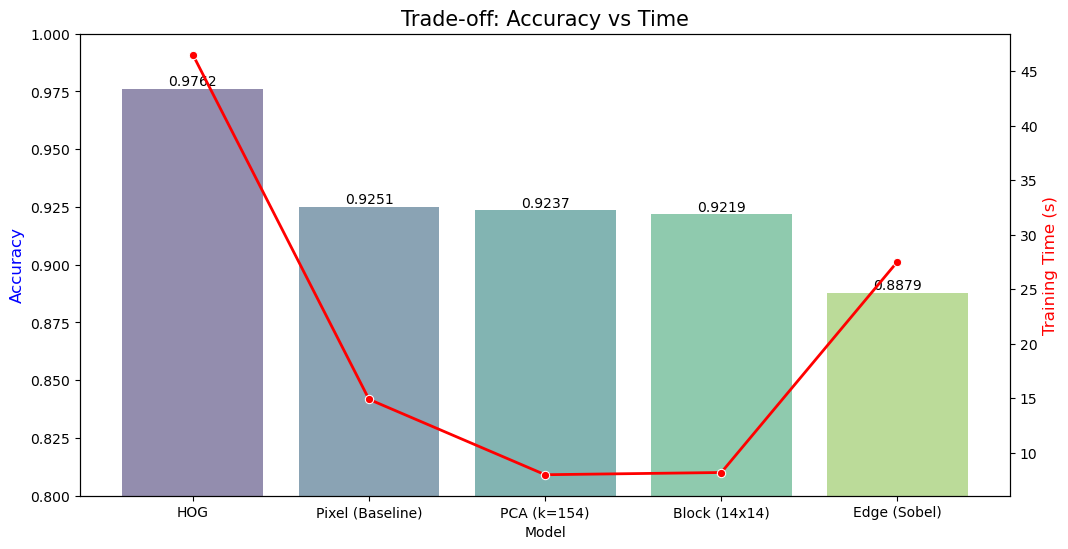

In [13]:
df_results = pd.DataFrame(results).sort_values(by="Accuracy", ascending=False)
display(df_results.style.background_gradient(cmap='Reds', subset=["Accuracy"]))

# Plot Accuracy vs Time
fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart for Accuracy
sns.barplot(data=df_results, x='Model', y='Accuracy', hue='Model', ax=ax1, palette='viridis', alpha=0.6, legend=False
)
ax1.set_ylabel('Accuracy', color='blue', fontsize=12)
ax1.set_ylim(0.8, 1.0)
for i in ax1.containers:
    ax1.bar_label(i, fmt='%.4f')

# Line chart for Training Time
ax2 = ax1.twinx()
sns.lineplot(data=df_results, x='Model', y='Time (s)', ax=ax2, color='red', marker='o', linewidth=2)
ax2.set_ylabel('Training Time (s)', color='red', fontsize=12)

plt.title('Trade-off: Accuracy vs Time', fontsize=15)
plt.show()

## Key Observations
- **HOG**: Highest accuracy (0.976) but slowest training (46.5s). Good feature representation.  
- **Pixel (Baseline)**: Moderate accuracy (0.925), many features (784), medium training time.  
- **PCA (k=154) & Block (14x14)**: Fewer features (154–196), fast training (~8s), accuracy close to baseline.  
- **Edge (Sobel)**: Lowest accuracy (0.888), long training, not effective.  

## Trade-off
- Accuracy vs. training time is evident: HOG excels in accuracy, PCA/Block balance speed and performance.  
- Edge features are ineffective for softmax regression.  

**Conclusion**: Use HOG for max accuracy; PCA or Block for faster training with reasonable performance.


In [17]:
# Detailed Classification Report for Selected Models
feature_models = list(models.keys())

for name in feature_models:
    if name in models:
        y_pred = models[name].predict(X_test)
        print_class_report(y_test, y_pred, name)


==================== DETAILED REPORT: Pixel (Baseline) ====================
Class  | Precision  | Recall     | F1-Score  
----------------------------------------------
0      | 0.9533     | 0.9786     | 0.9658
1      | 0.9669     | 0.9771     | 0.9720
2      | 0.9327     | 0.8866     | 0.9091
3      | 0.9094     | 0.9149     | 0.9121
4      | 0.9226     | 0.9348     | 0.9287
5      | 0.9083     | 0.8666     | 0.8870
6      | 0.9346     | 0.9551     | 0.9448
7      | 0.9322     | 0.9232     | 0.9277
8      | 0.8715     | 0.8984     | 0.8847
9      | 0.9113     | 0.9058     | 0.9085
----------------------------------------------

==================== DETAILED REPORT: Edge (Sobel) ====================
Class  | Precision  | Recall     | F1-Score  
----------------------------------------------
0      | 0.9173     | 0.9510     | 0.9339
1      | 0.9602     | 0.9559     | 0.9581
2      | 0.8909     | 0.8469     | 0.8684
3      | 0.8431     | 0.8723     | 0.8574
4      | 0.8964     | 0.8809 

**Key Observations from Classification Reports:**

1. **HOG Dominates Across All Classes:**  
   HOG consistently achieves 97-98% precision, recall, and F1-score for all digits, demonstrating robust feature representation with minimal per-class variance.

2. **Raw Features Show Class-Specific Weaknesses:**  
   - Pixel and Block models struggle most with digit **8** (precision ~87%) and digit **5** (recall ~86-87%), indicating these digits are harder to distinguish using raw intensity patterns.
   - Edge features perform worst on digit **8** (precision 79.7%), suggesting edge-based representation loses critical structural information.

3. **PCA Matches Raw Features:**  
   Despite dimensionality reduction (784→154), PCA preserves enough information to match or slightly exceed Pixel/Block performance, confirming that most variance in raw pixels is informative.

4. **Consistent Problem Classes:**  
   Digit **5** and digit **8** are systematically challenging across all methods, likely due to visual similarity with digits **3/6** and **0/6/9** respectively.

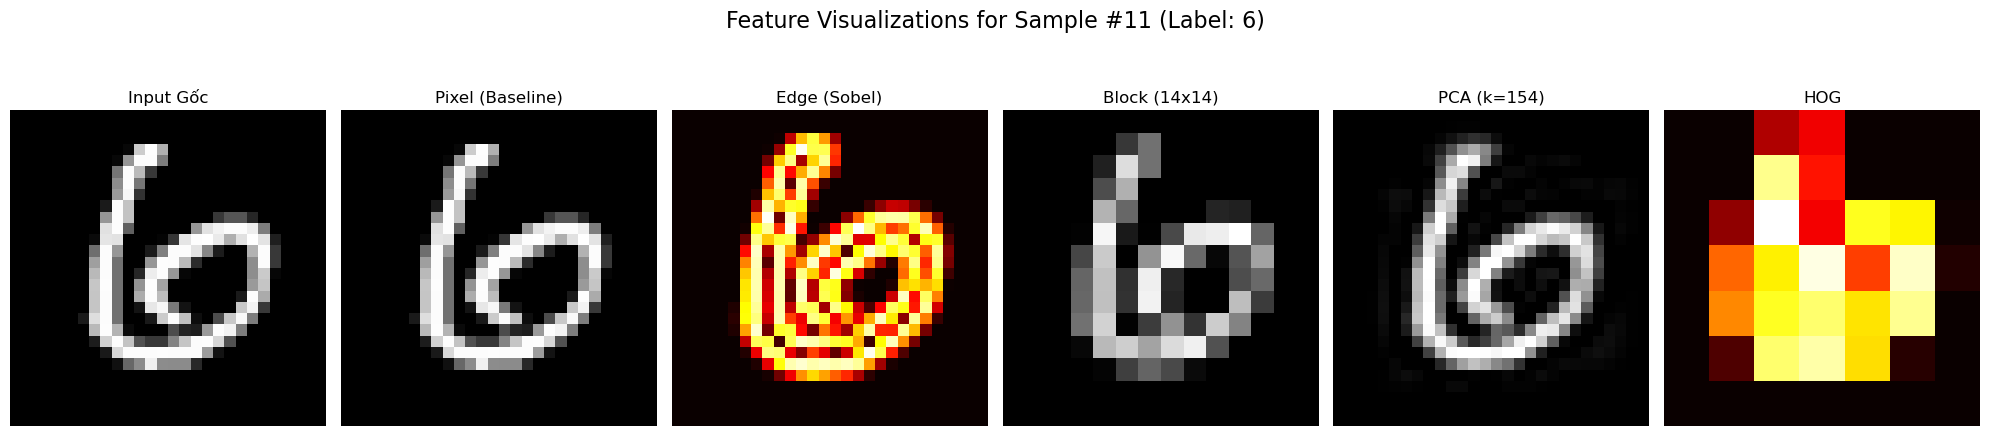

Visualizing PCA Features...


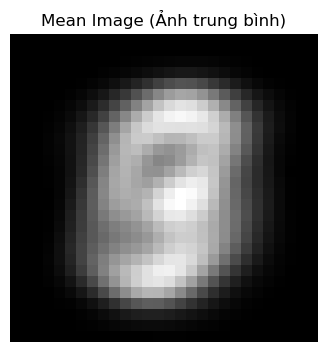

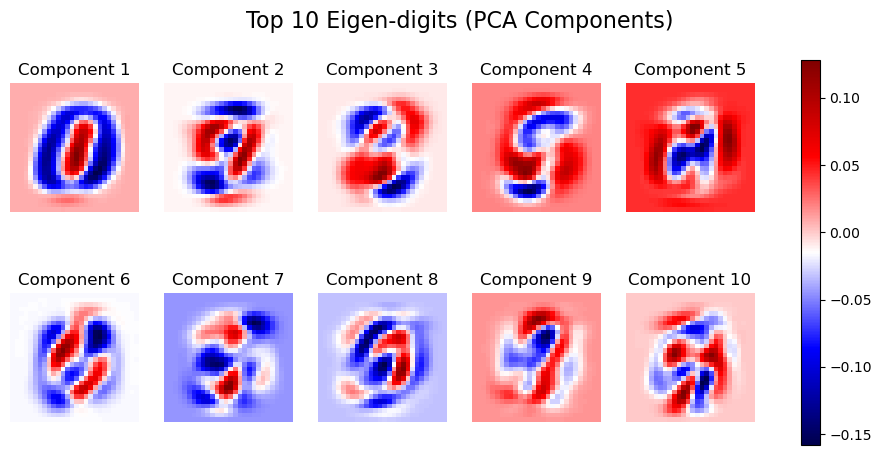

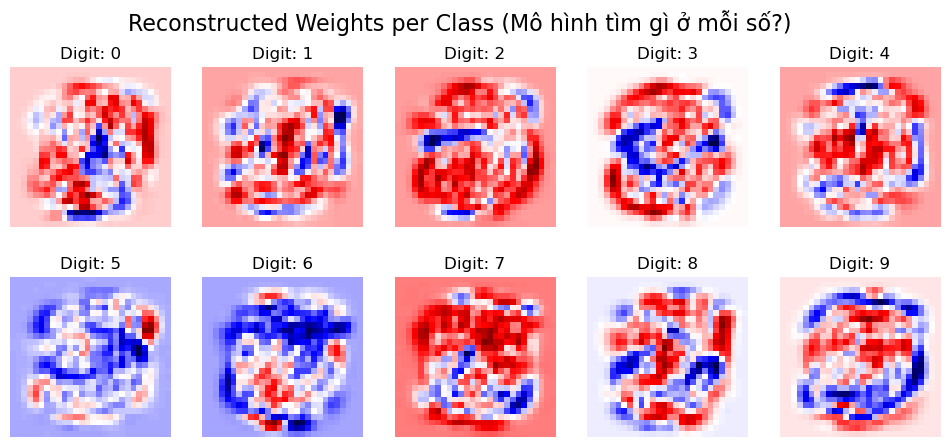

Visualizing HOG Features...


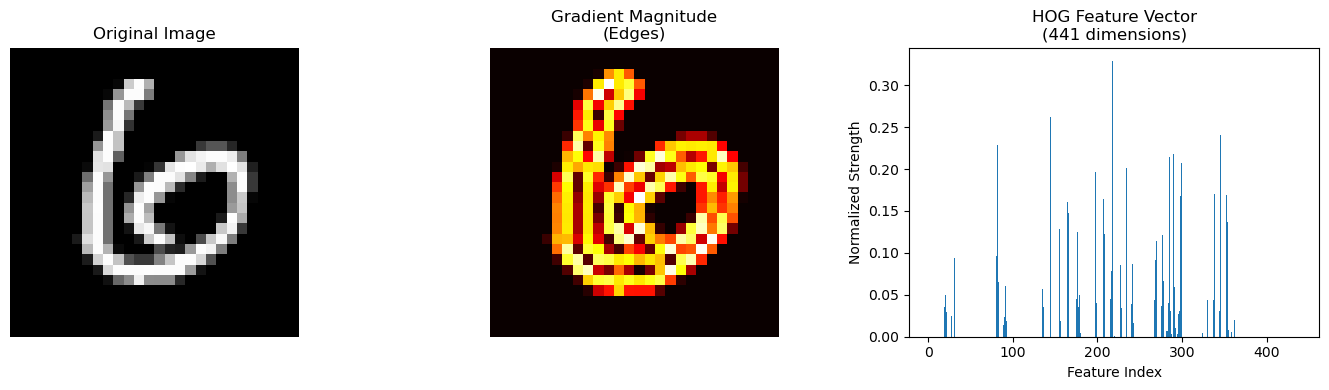

Visualizing HOG Features by Angle...


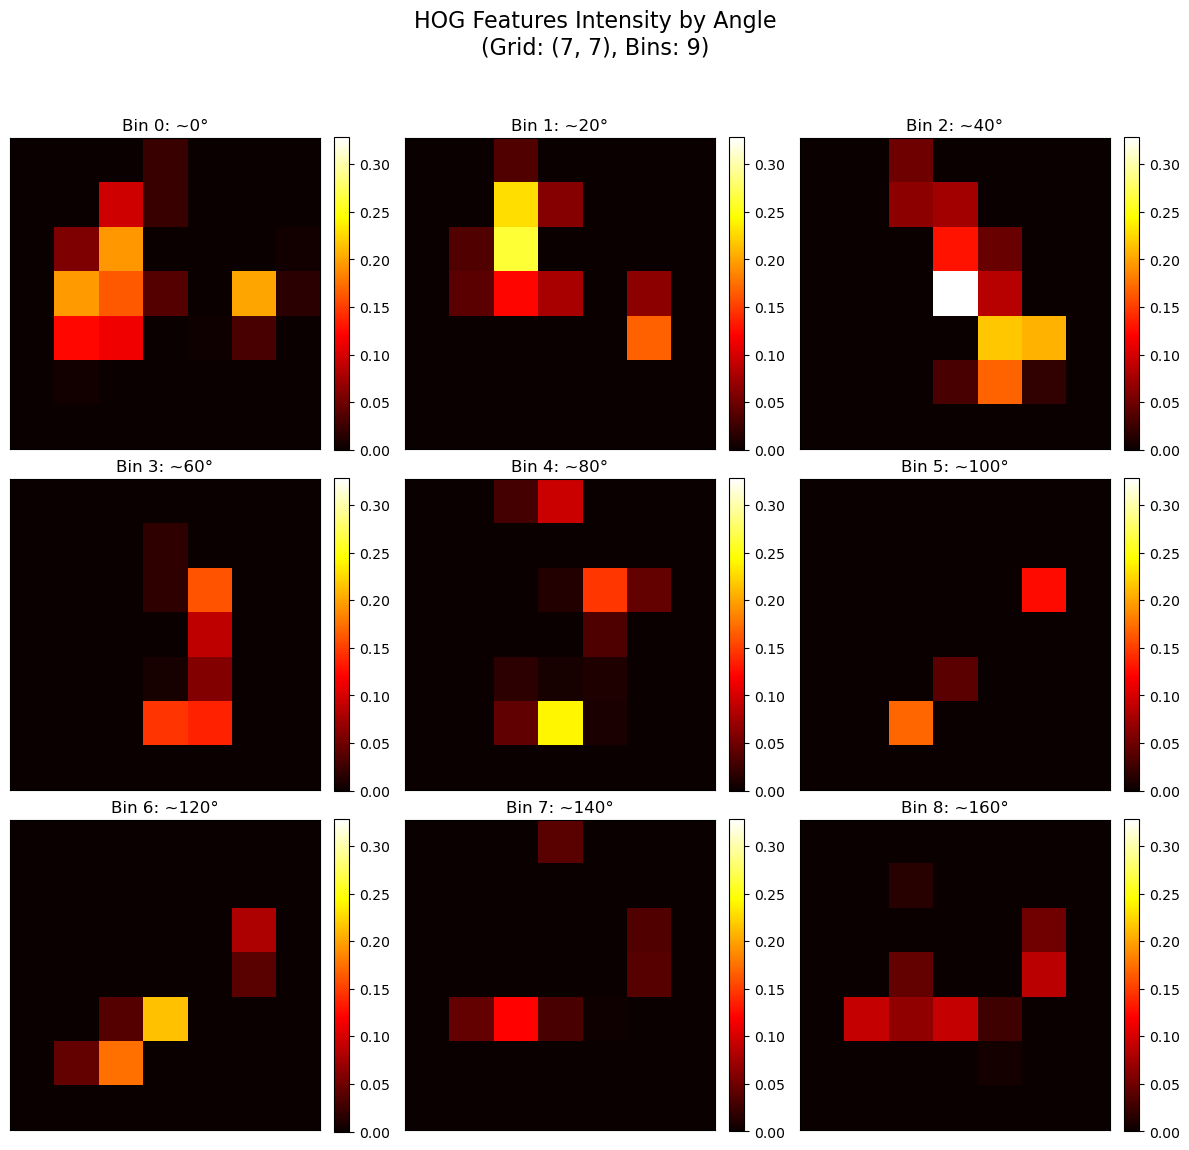

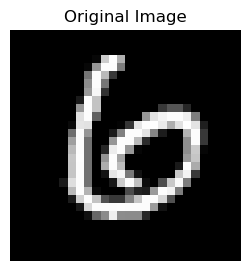

Visualizing Block Features...


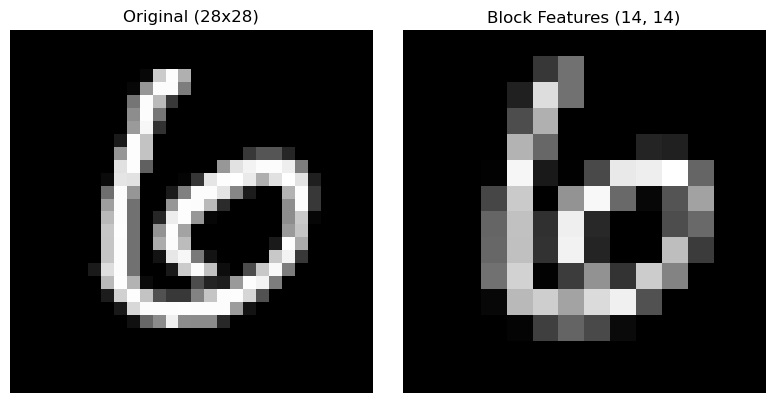

In [15]:
# Feature vector visualizations

sample_idx = 11  
sample_img = X_test[sample_idx]
sample_label = y_test[sample_idx]

feature_models = list(models.keys())

# General feature visualizations
plt.figure(figsize=(20, 5))
plt.suptitle(f"Feature Visualizations for Sample #{sample_idx} (Label: {sample_label})", fontsize=16)

ax0 = plt.subplot(1, len(feature_models) + 1, 1)
ax0.imshow(sample_img.reshape(28, 28), cmap='gray')
ax0.set_title("Input Gốc")
ax0.axis('off')

for i, name in enumerate(feature_models):
    if name in models:
        ax = plt.subplot(1, len(feature_models) + 1, i + 2)
        
        model_instance = models[name]
        viz_data = model_instance.get_feature_visualization(sample_img)
        
        cmap_type = 'hot' if 'HOG' in name or 'Edge' in name else 'gray'
        
        ax.imshow(viz_data, cmap=cmap_type)
        ax.set_title(f"{name}")
        ax.axis('off')

plt.tight_layout()
plt.show()

# Visualize feature representations for analysis OF PCA, HOG, Block
pca_model = models["PCA (k=154)"]
print("Visualizing PCA Features...")
visualize_PCA_features(pca_model) 

hog_model = models["HOG"]
print("Visualizing HOG Features...")
visualize_hog_features(hog_model, X_test[sample_idx])
print("Visualizing HOG Features by Angle...")
visualize_hog_features_order_by_angle(hog_model, X_test[sample_idx], grid_size=(7,7))

block_model = models["Block (14x14)"]
print("Visualizing Block Features...")
visualize_block_features(block_model, X_test[sample_idx])


Top 3 misclassifications for Pixel (Baseline)
 2 -> 8: 42
 7 -> 9: 33
 5 -> 8: 32

Top 3 misclassifications for HOG
 7 -> 2: 11
 8 -> 9: 10
 4 -> 9: 10

Top 3 misclassifications for HOG
 7 -> 2: 11
 8 -> 9: 10
 4 -> 9: 10


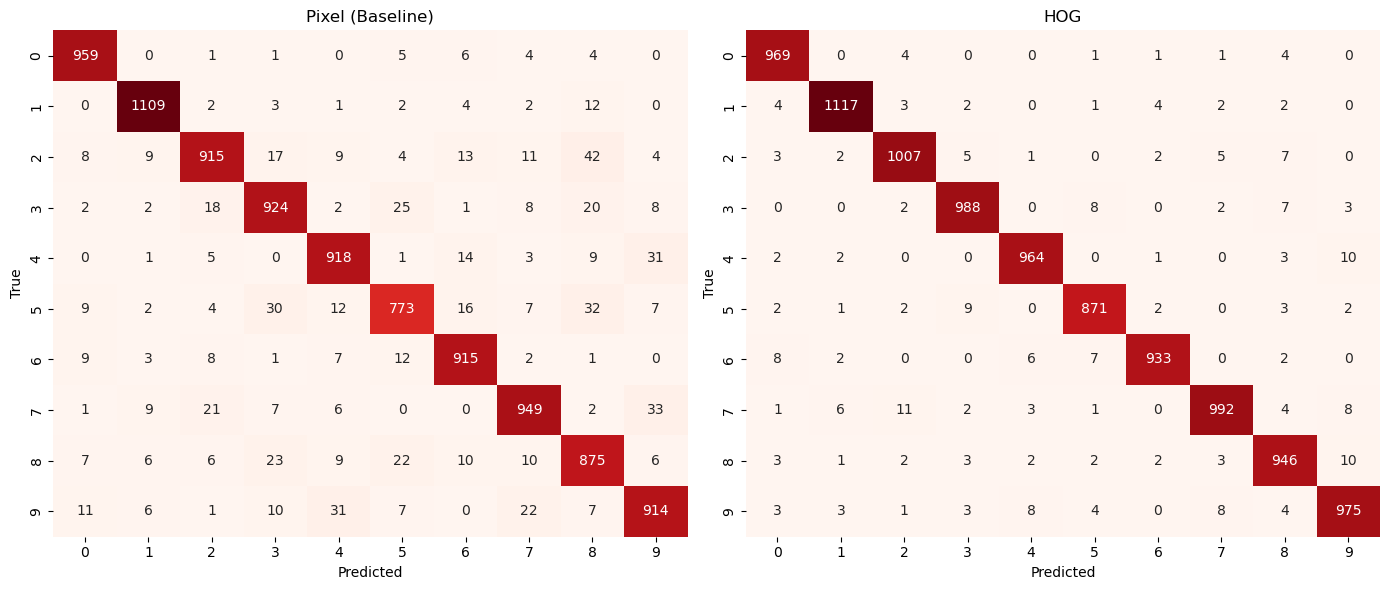

In [18]:
# Confusion Matrix Comparison

selected_models = ["Pixel (Baseline)", "HOG"] 

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, name in enumerate(selected_models):
    if name in models:
        model = models[name]
        
        # Predict
        y_pred = model.predict(X_test)
        
        cm = np.array(confusion_matrix(y_test, y_pred, num_classes=10))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[idx])
        axes[idx].set_title(f'{name}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('True')
        
        np.fill_diagonal(cm, 0) 
        
        top_errors = np.unravel_index(np.argsort(cm, axis=None)[-3:], cm.shape)
        
        print(f"\nTop 3 misclassifications for {name}")
        for i in range(2, -1, -1):
            true_label = top_errors[0][i]
            pred_label = top_errors[1][i]
            count = cm[true_label, pred_label]
            print(f" {true_label} -> {pred_label}: {count}")

plt.tight_layout()
plt.show()

**Key Observations:**

1. **HOG Reduces Misclassifications by ~75%:**  
   Top error counts drop from **42, 33, 32** (Pixel) to just **11, 10, 10** (HOG), demonstrating significantly improved discrimination between similar digits.

2. **Different Error Patterns:**  
   - **Pixel Baseline**: Struggles with **2→8** (42 errors), **7→9** (33), **5→8** (32) — confusion driven by overlapping raw pixel patterns.
   - **HOG**: Most errors are **7→2** (11), **8→9** (10), **4→9** (10) — more balanced error distribution across digit pairs.

3. **Digit 8 Problem Solved:**  
   HOG's gradient-based features eliminate the severe **2→8** and **5→8** confusions seen in raw pixel methods, confirming that orientation patterns better capture digit structure.

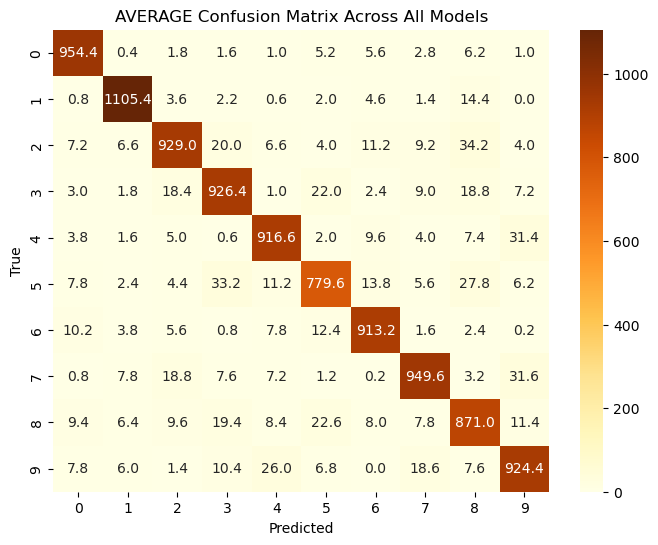

Number 2 is most often misclassified as number 8 (Average 34.2 errors/model)


In [19]:
avg_cm = np.zeros((10, 10), dtype=np.float32)
num_models = 0


for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = np.array(confusion_matrix(y_test, y_pred, num_classes=10))

    # Cumulate Confusion Matrix
    avg_cm += cm
    num_models += 1

avg_cm /= num_models

plt.figure(figsize=(8, 6))
sns.heatmap(avg_cm, annot=True, fmt='.1f', cmap='YlOrBr')
plt.title(f'AVERAGE Confusion Matrix Across All Models')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

# Phân tích
np.fill_diagonal(avg_cm, 0) # Remove diagonal
max_error_idx = np.unravel_index(np.argmax(avg_cm), avg_cm.shape)
print(f"Number {max_error_idx[0]} is most often misclassified as number {max_error_idx[1]} (Average {avg_cm[max_error_idx]:.1f} errors/model)")

**Key Insights from Average Confusion Matrix:**

1. **Universal Hardest Pair: 2→8 (34.2 errors/model)**  
   This is the most challenging misclassification across all models, suggesting inherent visual ambiguity when digit **2** has curved strokes resembling **8**.

2. **Secondary Problem Pairs:**  
   - **7→9** (31.6 errors) — Similar vertical structure with tail variations
   - **4→9** (31.4 errors) — Shared diagonal and vertical segments
   - **5→8** (27.8 errors) — Overlapping curved regions

3. **Well-Separated Digits:**  
   - **0, 1, 6** have minimal confusion with other digits (darker diagonals), indicating these shapes are distinctly recognizable across all feature extraction methods.

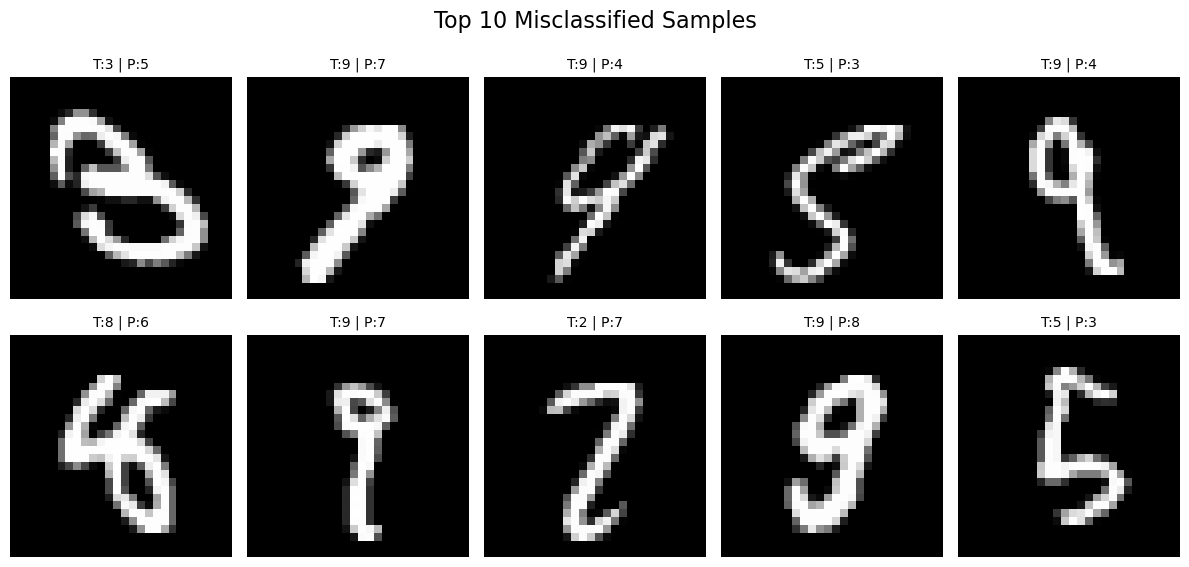

In [20]:
best_model_name = max(results, key=lambda x: x['Accuracy'])['Model']
best_model = models[best_model_name]
y_pred = best_model.predict(X_test)

# Find indices of wrong predictions
wrong_indices = np.where(y_pred != y_test)[0]

num_show = 10
rows, cols = 2, 5

fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
fig.suptitle("Top 10 Misclassified Samples", fontsize=16)

for i in range(num_show):
    idx = wrong_indices[i]
    img = X_test[idx]
    true_label = y_test[idx]
    pred_label = y_pred[idx]

    row = i // cols
    col = i % cols

    axes[row, col].imshow(img.reshape(28, 28), cmap='gray')
    axes[row, col].set_title(f"T:{true_label} | P:{pred_label}", fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

- Specific error distribution (5 cases of 9↔4/7, 3 cases of 5↔3, etc.)
- Root causes (incomplete strokes, non-standard writing, gradient ambiguity)
- A conclusion about HOG's limitations on edge cases